In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import corner
import json
# import cabinetry

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
import pyhf
from pyhf.contrib.viz import brazil
# pyhf.set_backend('jax')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import prepare_inference_combined
from pyhf_pymc import infer
from pyhf_pymc import make_op
from pyhf_pymc import plotting

%load_ext autoreload
%autoreload 

In [2]:
pyhf.set_backend('jax')

In [3]:
blue = '#7CA1CC' # '#A8B6CC'
rosa =  '#E57A77'

### Testing custom ur hyperparameters

In [4]:
## Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [6, 6, 10],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None}
        ]},

    {'name': 'background',
     'data': [550, 550, 550]
     ,
     'modifiers': [
        ## Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [650, 560, 670], 'lo_data': [40, 40, 43]}},
        {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [650, 560, 670], 'lo_data': [300, 350, 400]}},
        # ## Uncorrelated / Poisson
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [7, 8, 7.17]},
        {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 8, 7unconstr_priors = {
    'mu_ttbar': {'type': 'HalfNormal_Unconstrained', 'sigma': [0.4]}
}
.17]},
        # {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [8, 9, 10]},
         ]
         },    
                                 
    ]},
    ]
        }
)

data = model.expected_actualdata(model.config.suggested_init())

ur_hyperparameters = {}
ur_hyperparameters['Gamma'] = [[1., 0.1], [1., 0.1], [1., 0.1]]
ur_hyperparameters['Normal'] = [[0, 2], [0, 2], [0, 2]]

In [6]:
pyhf.set_backend('numpy')

with infer.model_conjugate(model, unconstr_priors, data, ur_hyperparameters):
    step = pm.Metropolis()
    post_data_combined = pm.sample(draws=n_draws, chains=1, step=step)
    # post_pred_combined = pm.sample_posterior_predictive(post_data_combined)
    # prior_pred_combined = pm.sample_prior_predictive(10_000)

NameError: name 'unconstr_priors' is not defined

In [98]:
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data_combined = pm.sample(draws=n_draws, chains=1, step=step)
    # post_pred_combined = pm.sample_posterior_predictive(post_data_combined)
    # prior_pred_combined = pm.sample_prior_predictive(10_000)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [corr_bkg]
>Metropolis: [corr_bkg1]
>Metropolis: [mu]
>Metropolis: [uncorr_bkg]
>Metropolis: [uncorr_bkg1]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [99]:
ur_hyperparameters

{'Gamma': [[1.0, 0.1], [1.0, 0.1], [1.0, 0.1]],
 'Normal': [[0, 2], [0, 2], [0, 2]]}

In [101]:
model.config.par_map

{'corr_bkg': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7f886d2fff50>},
 'corr_bkg1': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7f886d337c10>},
 'mu': {'slice': slice(2, 3, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x7f89404de410>},
 'uncorr_bkg': {'slice': slice(3, 6, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_poisson at 0x7f89286c2090>},
 'uncorr_bkg1': {'slice': slice(6, 9, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_poisson at 0x7f88b7431610>}}

In [102]:
model.config.parameters

['corr_bkg', 'corr_bkg1', 'mu', 'uncorr_bkg', 'uncorr_bkg1']

### Playing around with a SH4b workspace

In [3]:
with open("SH4b_Test.json") as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
workspace

model = workspace.model()

data = workspace.data(model, include_auxdata=False)

act_aux_data = workspace.data(model)
n_draws = 20_000

unconstr_priors = {
    'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [0.4]}
}


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    prior_pred = pm.sample_prior_predictive(100)

Sampling: [Expected_Data, FlowHistoSys_lambda46, FlowHistoSys_lambda47, FlowHistoSys_lambda48, FlowHistoSys_lambda49, FlowHistoSys_lambda50, GP, mu]


ValueError: lam < 0 or lam contains NaNs
Apply node that caused the error: poisson_rv{0, (0,), int64, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FFA81DB2500>), [50], 4, ExpDataOp.0)
Toposort index: 16
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(1,)), TensorType(int64, shape=()), TensorType(float64, shape=(None,))]
Inputs shapes: ['No shapes', (1,), (), (50,)]
Inputs strides: ['No strides', (8,), (), (8,)]
Inputs values: [Generator(PCG64) at 0x7FFA81DB2500, array([50]), array(4), 'not shown']
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [4]:
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=n_draws, chains=1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(10_000)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [FlowHistoSys_lambda46]
>Metropolis: [FlowHistoSys_lambda47]
>Metropolis: [FlowHistoSys_lambda48]
>Metropolis: [FlowHistoSys_lambda49]
>Metropolis: [FlowHistoSys_lambda50]
>Metropolis: [mu]
>Metropolis: [GP]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [Expected_Data]


Sampling: [Expected_Data, FlowHistoSys_lambda46, FlowHistoSys_lambda47, FlowHistoSys_lambda48, FlowHistoSys_lambda49, FlowHistoSys_lambda50, GP, mu]


ValueError: lam < 0 or lam contains NaNs
Apply node that caused the error: poisson_rv{0, (0,), int64, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FFAF877EF80>), [50], 4, ExpDataOp.0)
Toposort index: 16
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(1,)), TensorType(int64, shape=()), TensorType(float64, shape=(None,))]
Inputs shapes: ['No shapes', (1,), (), (50,)]
Inputs strides: ['No strides', (8,), (), (8,)]
Inputs values: [Generator(PCG64) at 0x7FFAF877EF80, array([50]), array(4), 'not shown']
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

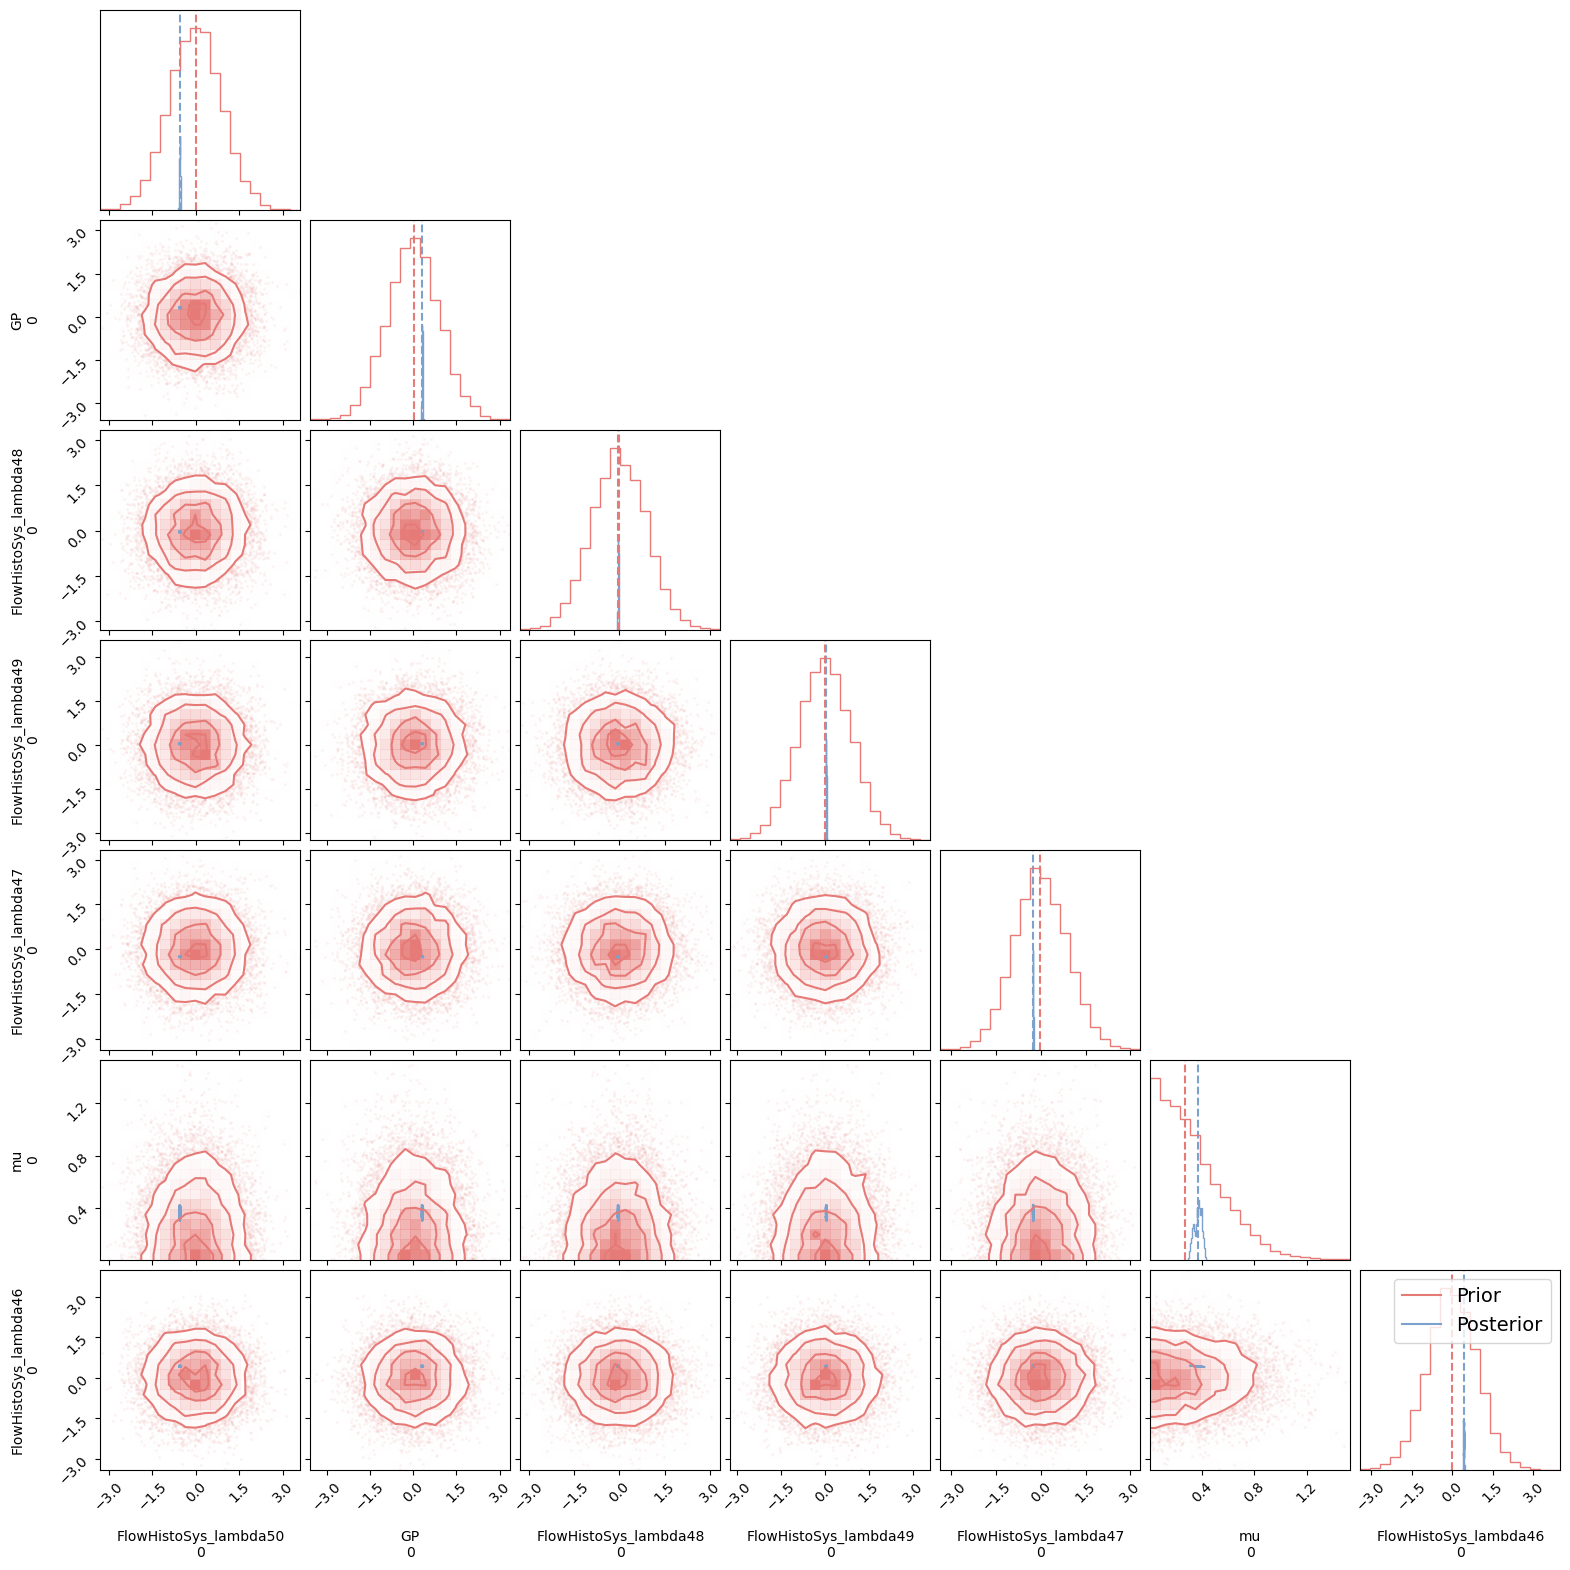

In [144]:
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);
corner.corner(prior_pred.prior, quantiles=[0.5], color = pink, fig = a);


import matplotlib.lines as mlines
plt.legend(handles=[
            (mlines.Line2D([], [], color=rosa, label='Prior')),
            (mlines.Line2D([], [], color=blue, label='Posterior'))
        ], loc="upper right", fontsize=14)

In [5]:
plotting.prior_posterior_predictives(model, data, post_pred, prior_pred, 10)
plt.title('Sh4b, toy signal')
plt.xlabel('$m_{{SH}}$')

NameError: name 'prior_pred' is not defined

array([[<Axes: title={'center': 'FlowHistoSys_lambda50'}>,
        <Axes: title={'center': 'FlowHistoSys_lambda50'}>],
       [<Axes: title={'center': 'GP'}>, <Axes: title={'center': 'GP'}>],
       [<Axes: title={'center': 'FlowHistoSys_lambda48'}>,
        <Axes: title={'center': 'FlowHistoSys_lambda48'}>],
       [<Axes: title={'center': 'FlowHistoSys_lambda49'}>,
        <Axes: title={'center': 'FlowHistoSys_lambda49'}>],
       [<Axes: title={'center': 'FlowHistoSys_lambda47'}>,
        <Axes: title={'center': 'FlowHistoSys_lambda47'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'FlowHistoSys_lambda46'}>,
        <Axes: title={'center': 'FlowHistoSys_lambda46'}>]], dtype=object)

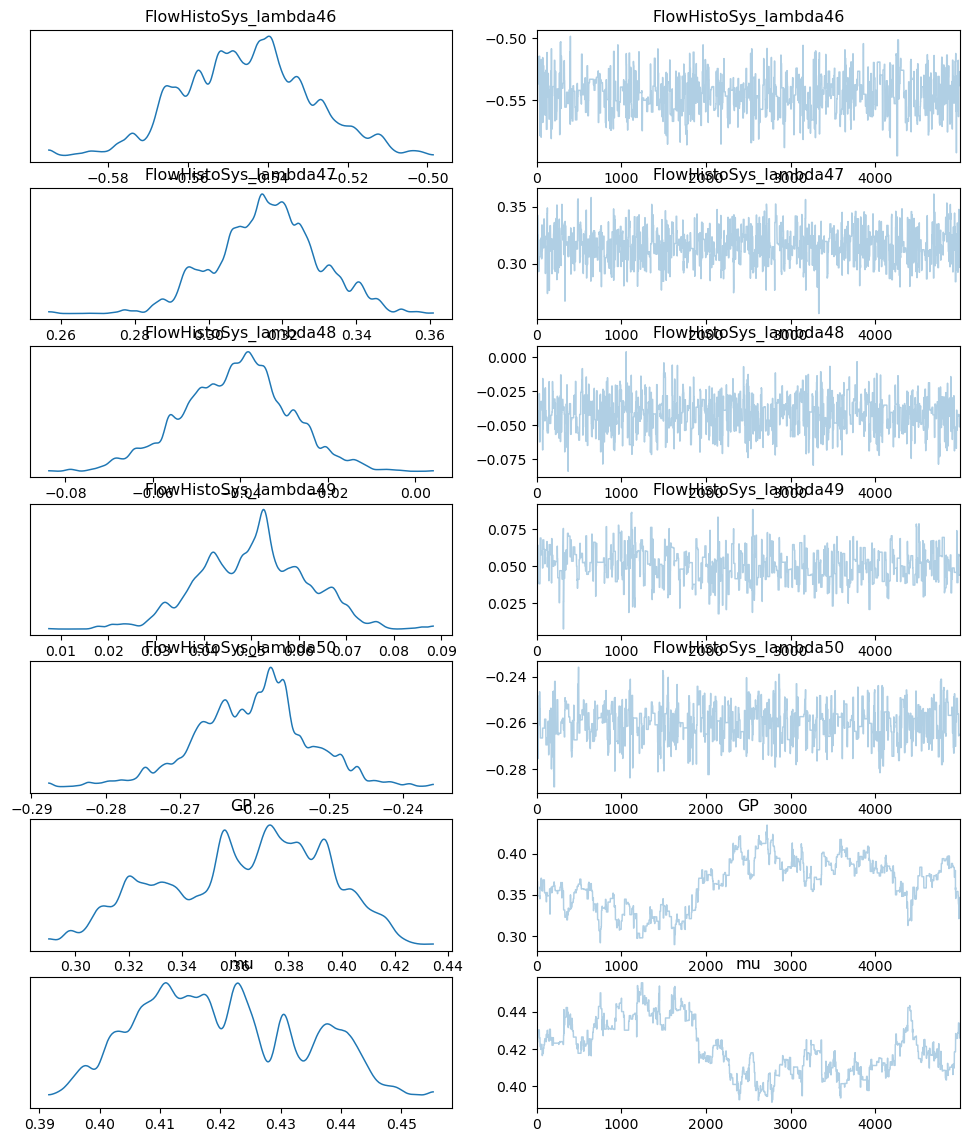

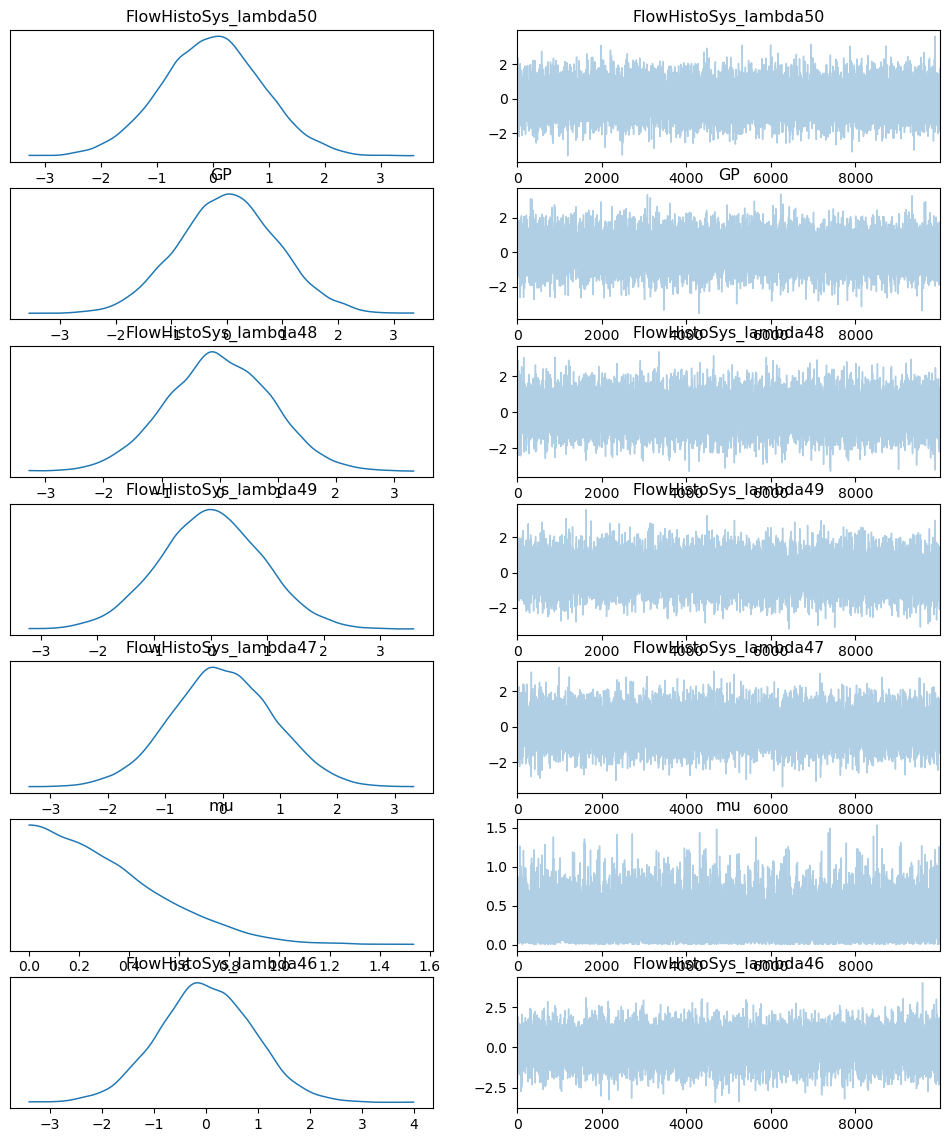

In [159]:
az.plot_trace(post_data)
az.plot_trace(prior_pred.prior)

In [156]:
with open("SH4b_Test.json") as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
workspace

model = workspace.model()

pyhf.set_backend('numpy')

In [153]:
poi_values = np.linspace(0.1, 5, 50)
obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
    act_aux_data, model, poi_values, level=0.05, return_results=True
)
print(f"Upper limit (obs): μ = {obs_limit:.4f}")
print(f"Upper limit (exp): μ = {exp_limits[2]:.4f}")

/home/iwsatlas1/mhorstm/miniconda3/envs/Bayesian_pyhf/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Upper limit (obs): μ = 1.3466
Upper limit (exp): μ = 0.9355


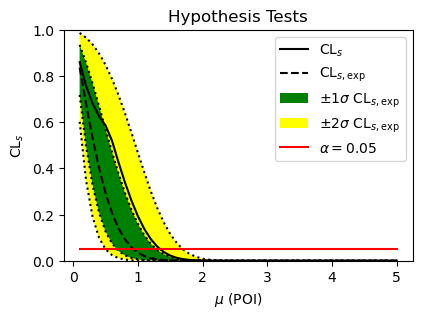

In [157]:
fig, ax = plt.subplots()
fig.set_size_inches(4.5, 3)
ax.set_title("Hypothesis Tests")

artists = brazil.plot_results(poi_values, results, ax=ax)

In [160]:
ws = cabinetry.workspace.load(f'WorkspaceCombFit_alpha{alpha}_year16_SR_125_{mS}_CR.json');
model, data = cabinetry.model_utils.model_and_data(ws);
cabinetry.visualize.modifier_grid(model)

NameError: name 'cabinetry' is not defined